In [1]:
#Accessing dataset from google drive
from google.colab import drive 
drive.mount('/mntDrive')
projectPath='/mntDrive/My Drive/RL/Project/'

Mounted at /mntDrive


In [ ]:
!pip uninstall tensorflow
!pip uninstall Keras
!pip install tensorflow==1.15
!pip install keras==2.2.4

In [3]:
import tensorflow as tf
print(tf.VERSION)
print(tf.keras.__version__)

1.15.0
2.2.4-tf


In [4]:
#Importing required libraries
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
import gym
import tensorflow as tf
import keras
import random
import numpy as np
import datetime as dt
import imageio
from keras.models import Model,load_model
from keras.layers import Input,Dense,Lambda,Add,Conv2D,Flatten
from keras.optimizers import Adam,RMSprop
import cv2
from IPython import display
import pickle
import matplotlib.pyplot as plt 
import pickle

#Setting GPU
os.environ['CUDA_VISIBLE_DEVICES']='1'

#For threading, parameters import
from keras import backend as K
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import threading
from threading import Thread, Lock
import time

# configure Keras and TensorFlow sessions and graph
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)
K.set_session(sess)
graph = tf.get_default_graph()

Using TensorFlow backend.


# Initial Parameters

In [ ]:
GAMMA = 0.99
POST_PROCESS_IMAGE_SIZE = (105, 80, 1)
NUM_FRAMES = 4
LEARNING_RATE = 0.000025

# Model

In [ ]:
def image_preprocess(image, new_size=(105, 80)):
    # convert to greyscale, resize and normalize the image
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, new_size)
    image = image / 255
    return image.eval(session=tf.Session())

#Defining the structure of the neural network used
def A3CModel(inputShape,numActions,learningRate):
  inp=Input(inputShape)
  conv1=keras.layers.Conv2D(filters=16,kernel_size=(8,8),strides=(4,4),activation='relu')(inp)
  conv2=keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(2,2),activation='relu')(conv1)
  flatten=keras.layers.Flatten()(conv2)
  #flatten=keras.layers.Flatten()(inp)
  fc=keras.layers.Dense(256,activation='relu', kernel_initializer=keras.initializers.he_normal())(flatten)

  actionPolicy=keras.layers.Dense(numActions,activation="softmax",kernel_initializer=keras.initializers.he_normal())(fc)
  valueEstimates=keras.layers.Dense(1,kernel_initializer=keras.initializers.he_normal())(fc)
  
  actorAgent=Model(inputs=inp,outputs=actionPolicy)
  actorAgent.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=LEARNING_RATE))

  criticAgent=Model(inputs=inp,outputs=valueEstimates)
  criticAgent.compile(loss='mse', optimizer=RMSprop(lr=LEARNING_RATE))

  return actorAgent,criticAgent


#Agent class
class A3CAgent:
  def __init__(self,currentEpisode=0,totalEpisodes=50,maxAvgReward=-1000,scores=[],episodes=[],average=[]):
    self.env=gym.make("SpaceInvaders-v0")
    self.numActions=self.env.action_space.n
    self.learningRate=0.000025
    self.TOTAL_EPISODES=totalEpisodes
    self.currentEpisode=currentEpisode
    self.maxAvgReward=maxAvgReward

    self.lock=Lock()
    self.ROWS=105
    self.COLS=80
    self.NUM_FRAMES=4
    self.BATCH_SIZE=1

    #Stroring in memory
    self.scores=scores
    self.episodes=episodes
    self.average=average
    self.stateSize=(self.BATCH_SIZE,self.ROWS,self.COLS,self.NUM_FRAMES)
    self.inputToModelSize=(self.ROWS,self.COLS,self.NUM_FRAMES)

    #Saving the model
    self.NameModel=projectPath+'/A3C'


    #Defining the actor and critic models
    self.actor,self.critic=A3CModel(inputShape=self.inputToModelSize,numActions=self.numActions,learningRate=self.learningRate)
    
    #Working with multithreading
    self.actor._make_predict_function()
    self.critic._make_predict_function()

    global graph
    graph = tf.get_default_graph()

  #Taking an action
  def takeAction(self,state):
    #print("State shape while taking action : ",state.shape)
    predictedProbabilites=self.actor.predict(np.reshape(state,(state.shape[0],state.shape[1],state.shape[2],state.shape[3])))[0]
    chosenAction=np.random.choice(self.numActions,p=predictedProbabilites)
    return chosenAction

  #Loading the model
  def load(self,actorName,criticName):
    self.actor=load_model(actorName,compile=False)
    self.actor.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=LEARNING_RATE))
  
    if criticName!='':
        self.critic=load_model(criticName, compile=False)
        self.critic.compile(loss='mse', optimizer=RMSprop(lr=LEARNING_RATE))

  #Saving the model
  def save(self):
    self.actor.save(self.NameModel+'_Actor.h5')
    self.critic.save(self.NameModel+'_Critic.h5')
  
  def CalculateAverage(self, score, episode):
      self.scores.append(score)
      self.episodes.append(episode)
      self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))

      return self.average[-1]
  
  def GetImage(self,frame,imageMemory):
    #print("Before shape : ",imageMemory.shape)
    if imageMemory.shape == (*self.stateSize,1):
      imageMemory = np.squeeze(imageMemory,axis=4)
      #print("After Shape : ",imageMemory.shape)
    #newFrame=frame 
    newFrame=image_preprocess(frame)
    #print("Image memory 0 : ",imageMemory[0].shape)
    imageMemory[0]=np.roll(imageMemory[0],1,axis=2) 
    #print("After Shape Preprocess, Image Memory: ",imageMemory.shape)
    #print("Single state shape : ",imageMemory[0,:,:,0].shape)
    #print("Frame shape : ",newFrame.shape)

    imageMemory[0,:,:,0]=np.reshape(newFrame,(newFrame.shape[0],newFrame.shape[1]))
    return np.expand_dims(imageMemory,axis=-1)

  def saveVariables(self):
    pickleFile=open(projectPath+"maxAvgReward1.pickle","wb")
    pickle.dump(self.maxAvgReward,pickleFile)
    pickleFile.close()

    pickleFile=open(projectPath+"scores1.pickle","wb")
    pickle.dump(self.scores,pickleFile)
    pickleFile.close()

    pickleFile=open(projectPath+"currentEpisode1.pickle","wb")
    pickle.dump(self.currentEpisode,pickleFile)
    pickleFile.close()

    pickleFile=open(projectPath+"episodes1.pickle","wb")
    pickle.dump(self.episodes,pickleFile)
    pickleFile.close()

    pickleFile=open(projectPath+"averagea3c.pickle","wb")
    pickle.dump(self.average,pickleFile)
    pickleFile.close()

    """
    pickleFile=open(projectPath+"avgRewarda2c.pickle","wb")
    pickle.dump(averageValues,pickleFile)
    pickleFile.close()
    """

  def loadVariables(self):
    pickleFile=open(projectPath+"currentEpisode.pickle","rb")
    self.currentEpisode=pickle.load(pickleFile)
    pickleFile.close()

    pickleFile=open(projectPath+"maxAvgReward.pickle","rb")
    self.maxAvgReward=pickle.load(pickleFile)
    pickleFile.close()

    pickleFile=open(projectPath+"scores.pickle","rb")
    self.scores=pickle.load(pickleFile)
    pickleFile.close()

    pickleFile=open(projectPath+"episodes.pickle","rb")
    self.episodes=pickle.load(pickleFile)
    pickleFile.close()

    pickleFile=open(projectPath+"average.pickle","rb")
    self.average=pickle.load(pickleFile)
    pickleFile.close()


  def reset(self, env):
      imageMemory=np.zeros(self.stateSize)
      frame = env.reset()
      for i in range(self.NUM_FRAMES):
          state=self.GetImage(frame,imageMemory)
      #print("Reset State shape : ",state.shape)
      return state

  def step(self,action,env,imageMemory):
      nextState,reward,done,info=env.step(action)
      nextState=self.GetImage(nextState,imageMemory)
      return nextState,reward,done,info

  def runA2C(self):
      for episodeNum in range(self.currentEpisode,self.TOTAL_EPISODES,1):
          state=self.reset(self.env)
          state=np.reshape(state,(state.shape[0],state.shape[1],state.shape[2],state.shape[3]))

          score=0
          done=False
          SAVING=''
          states=[]
          actions=[]
          rewards=[]
          currentTimeStep=0

          while done==False:
              if currentTimeStep%50==0:
                print("Episode : ",episodeNum,"  current time step : ",currentTimeStep)
              #print("Score : ",score)
              action=self.takeAction(state)
              nextState,reward,done,_=self.step(action, self.env, state)
              nextState=np.reshape(nextState,(nextState.shape[0],nextState.shape[1],nextState.shape[2],nextState.shape[3]))

              states.append(state)
              oneHotEncodedAction=np.zeros([self.numActions])
              oneHotEncodedAction[action]=1

              #print("State : ",state.shape,"  reward : ",reward)
              #print("Before, Next state : ",nextState.shape)
              #print("Action : ",action,"  reward : ",reward)

              #Predict values uisng Critic network
              currentStateValue=self.critic.predict(state)[:, 0]
              nextStateValue=self.critic.predict(nextState)[:, 0]
              #print("Predicted current State shape : ",currentStateValue[0])
              #print("Next state value : ",nextStateValue[0])
              modificationRequired=reward+(GAMMA*nextStateValue) - currentStateValue
              
              #print("OneHot Encoded shape : ",oneHotEncodedAction.shape)
              #print("Modifications required : ",modificationRequired)
              #Training actor and critic networks
              
              self.actor.fit(state,np.vstack([oneHotEncodedAction]),sample_weight=modificationRequired,epochs=1,verbose=0,batch_size=1)
              self.critic.fit(state,reward+(GAMMA*nextStateValue),epochs=1,verbose=0,batch_size=1)

              actions.append(oneHotEncodedAction)
              rewards.append(reward)
              state=nextState
              score+=reward
              currentTimeStep+=1

              if done:
                 average=self.CalculateAverage(score,episodeNum)
                 if average>=self.maxAvgReward:
                    self.maxAvgReward=average
                    self.save()
                    SAVING="SAVING"
                 else:
                    SAVING=""
                 print("Episode : ",episodeNum,"/",self.TOTAL_EPISODES,"  score : ",score,"   average : ",average)
                 self.saveVariables()

      self.env.close()


  def train(self,numThreads):
    self.env.close()

    #Each thread has one environment
    environments=[]
    for threadIndex in range(numThreads):
        environments.append(gym.make("SpaceInvaders-v0"))
    
    #Creating threads to handle different environments
    threads=[]
    for threadIndex in range(numThreads):
        threads.append(threading.Thread(target=self.trainThreading,
                                         daemon=True,
                                         args=(self,environments[threadIndex],threadIndex)))
    #print("Reached here")
    for thread in threads:
      time.sleep(2)
      #print("Thread : ",thread,"  started ")
      thread.start()
    
    for thread in threads:
      time.sleep(10)
      thread.join()

  def trainThreading(self,agent,env,thread):
    global graph
    with graph.as_default():
       while self.currentEpisode<self.TOTAL_EPISODES:
          #Reset episode
          score=0
          done=False
          SAVING=''
          states=[]
          actions=[]
          rewards=[]
          state=self.reset(env)
          state=np.reshape(state,(state.shape[0],state.shape[1],state.shape[2],state.shape[3]))
          currentTimeStep=0

          while done==False:
              if currentTimeStep%50==0:
                  print("Episode : ",self.currentEpisode,"  current time step : ",currentTimeStep,"   thread : ",thread)
              #print("Score : ",score)
              action=agent.takeAction(state)
              nextState,reward,done,_=self.step(action, env, state)
              nextState=np.reshape(nextState,(nextState.shape[0],nextState.shape[1],nextState.shape[2],nextState.shape[3]))

              states.append(state)
              oneHotEncodedAction=np.zeros([self.numActions])
              oneHotEncodedAction[action]=1
              
              #print("State : ",state.shape,"  reward : ",reward)
              #print("Before, Next state : ",nextState.shape)
              #print("Action : ",action,"  reward : ",reward)

              
              self.lock.acquire()
              #Predict values uisng Critic network
              currentStateValue=self.critic.predict(state)[:, 0]
              nextStateValue=self.critic.predict(nextState)[:, 0]
              #print("Predicted current State shape : ",currentStateValue[0])
              #print("Next state value : ",nextStateValue[0])
              modificationRequired=reward+(GAMMA*nextStateValue) - currentStateValue
              #print("OneHot Encoded shape : ",oneHotEncodedAction.shape)
              #print("Modifications required : ",modificationRequired)
              #Training actor and critic networks

              self.actor.fit(state,np.vstack([oneHotEncodedAction]),sample_weight=modificationRequired,epochs=1,verbose=0,batch_size=1)
              self.critic.fit(state,reward+(GAMMA*nextStateValue),epochs=1,verbose=0,batch_size=1)
              
              self.lock.release()

              state=nextState
              score+=reward
              actions.append(oneHotEncodedAction)
              rewards.append(reward)
              currentTimeStep+=1

          with self.lock:
              average=self.CalculateAverage(score,self.currentEpisode)
              if average>=self.maxAvgReward:
                  self.maxAvgReward=average
                  self.save()
                  SAVING='SAVING'
              else:
                  SAVING=''
              
              print("Episode : ",self.currentEpisode,"/",self.TOTAL_EPISODES,"  Thread : ",thread,"  score : ",score,"   average : ",average,"  saving : ",SAVING)
              if self.currentEpisode<self.TOTAL_EPISODES:
                  self.currentEpisode+=1
              self.saveVariables()

       env.close()
    
  def test(self,actorName,criticName):
    self.load(actorName,criticName)
    
    img = plt.imshow(self.env.render(mode='rgb_array')) # only call this once
    for episodeNum in range(100):
        state=self.reset(self.env)
        state=np.reshape(state,(state.shape[0],state.shape[1],state.shape[2],state.shape[3]))

        done=False
        score=0

        while not done:
            #rendering = lambda : plt.imshow(self.env.render(mode='rgb_array'))
            #rendering()
            #self.env.render()
            img.set_data(self.env.render(mode='rgb_array')) # just update the data
            display.display(plt.gcf())
            display.clear_output(wait=True)
            action=np.argmax(self.actor.predict(state))
            state,reward,done,_=self.step(action,self.env,state)
            state=np.reshape(state,(state.shape[0],state.shape[1],state.shape[2],state.shape[3]))

            score+=reward

            if done:
                print("Testing - Episode : ",episodeNum,"  score : ",score)
                break
      
    self.env.close()

In [ ]:
if __name__=='__main__':
    agent=A3CAgent(currentEpisode=0,totalEpisodes=50)
    #agent.load(projectPath+'/A3C_Actor.h5',projectPath+'/A3C_Critic.h5')
    #agent.loadVariables()

    #Use A2C
    #agent.runA2C()

    #Use A3C
    #agent.train(numThreads=5)

    #For visualizing the output
    agent.test(projectPath+'/A2C_Actor.h5','')


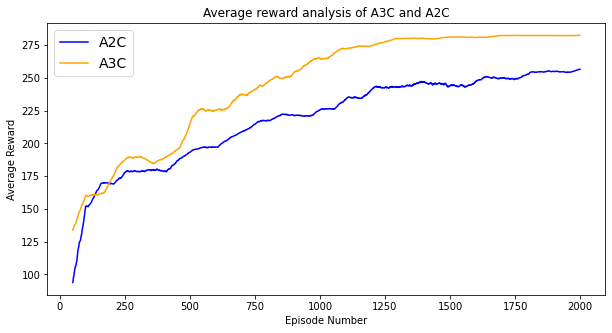

In [5]:
#Plotting the graphs for different distributions
def plotGraph(xValues1,yValues1,xValues2,yValues2,xLabel,yLabel,graphTitle):
    f,ax=plt.subplots(figsize=(10,5))
    plt.plot(xValues1,yValues1,color='blue',label='A2C')
    plt.plot(xValues2,yValues2,color='orange',label='A3C')
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(graphTitle)
    ax.legend(fontsize = 14)
    plt.show()

pickleFile=open(projectPath+"avgRewarda2c.pickle","rb")
avgRewarda2c=pickle.load(pickleFile)
pickleFile.close()

pickleFile=open(projectPath+"avgRewarda3c.pickle","rb")
avgRewarda3c=pickle.load(pickleFile)
pickleFile.close()

xValues=[]

for episode in range(50,50+len(avgRewarda3c),1):  
    xValues.append(episode)    

plotGraph(xValues,avgRewarda2c,xValues,avgRewarda3c,'Episode Number','Average Reward','Average reward analysis of A3C and A2C')   